In [8]:
import pandas as pd
import gudhi as gd
import gudhi.representations
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import preprocessing
from mpmath import mp, mpf
from random import gauss
from random import seed
from random import uniform

In [9]:
df = pd.read_csv('/home/andrija/Desktop/topologija/trading_data.csv')
df = df.dropna()
df.head()

,Date,Sip,Russel,Djia,Nasdaq
1,1987-12-24,-0.004474,0.006518,-0.002981,0.005115
2,1987-12-28,-0.025966,-0.021531,-0.028764,-0.023073
3,1987-12-29,-0.003999,-0.005900,-0.008310,-0.000307
4,1987-12-30,0.013281,0.010093,0.011973,0.012821
5,1987-12-31,-0.003152,0.007669,-0.005796,0.002423


In [10]:
def get_window(df, start, len):
    points = df.iloc[start:start+len, 1:].to_numpy()
    return points

In [11]:
def get_landscape_vector(data):
    acX = gd.AlphaComplex(points=data).create_simplex_tree()
    acX.persistence()
    LS = gd.representations.Landscape(resolution=1000)
    L = LS.fit_transform([acX.persistence_intervals_in_dimension(1)])
    return L

In [12]:
def rescale(norm):
    min_max_scaler = preprocessing.MinMaxScaler()
    v = np.array(norm).reshape(-1, 1)
    v_scaled = min_max_scaler.fit_transform(v)
    return v_scaled

In [13]:
def diff_norms(df, p_norm, window_size=50, starting_index = 5000, sample_len=1000, is_simulation = False):
    windows = [get_window(df, i + starting_index, window_size) for i in range(sample_len)]
    landscapes = [get_landscape_vector(window) for window in windows]
    norms = [np.linalg.norm((landscapes[i+1] - landscapes[i]), ord=p_norm) for i in range(len(landscapes) -1)]
    if not is_simulation:
        norms = rescale(norms)
        time = df.iloc[starting_index:starting_index+sample_len-1, 0]
        time = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in time]
    else:
        time = [i for i in range(sample_len - 1)]
    return norms, time


In [94]:
norm1, time = diff_norms(df, 1)
norm2, time = diff_norms(df, 2)

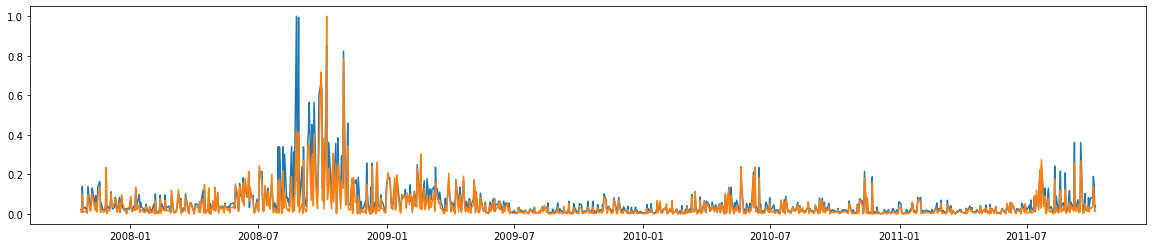

In [95]:
fig = plt.figure(figsize=(20, 4))
plt.plot(time, norm1)
plt.plot(time, norm2)
plt.show()

In [14]:
def generate_sample(sigma = 1, length = 100):
    delta = uniform(-0.1, 0.1)
    series = [gauss(0.0, (sigma + delta)**2) for i in range(length)]
    
    
    return series


In [15]:
def generate_point_cloud(sigma=1):
    columns = []
    columns.append([i for i in range(100)])
    for i in range(1,5):
        columns.append(pd.Series(generate_sample(sigma, 100)))
    point_cloud = pd.DataFrame(columns)
    point_cloud = point_cloud.transpose()
    return point_cloud

In [16]:
def norm_change(num_iterations=100):
    l1_norms = []
    l2_norms = []
    for i in range(num_iterations):
        dots = generate_point_cloud(i*0.1)
        norm1_sim, time = diff_norms(df=dots, p_norm=1, window_size=50, starting_index = 0, sample_len=90, is_simulation = True)
        norm2_sim, time = diff_norms(df=dots, p_norm=2, window_size=50, starting_index = 0, sample_len=90, is_simulation = True)
        l1_norms.append(np.mean(norm1_sim))
        l2_norms.append(np.mean(norm2_sim))

    return l1_norms, l2_norms


In [17]:
l1, l2 = norm_change()

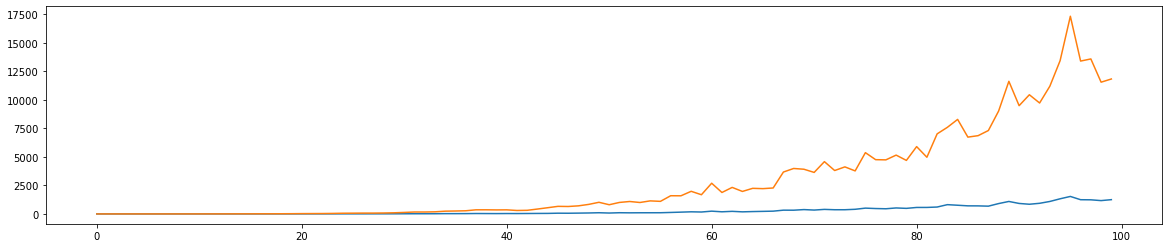

In [18]:
fig = plt.figure(figsize=(20, 4))
plt.plot([i for i in range(100)], l1)
plt.plot([i for i in range(100)], l2)
plt.show()